In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.decomposition import PCA, IncrementalPCA, TruncatedSVD
from sklearn.utils.extmath import randomized_svd
from sklearn.datasets import fetch_openml
from oja_pca import OjaPCA
import torch
import sys
import os
sys.path.append(os.path.abspath(".."))
from online_psp.online_psp.ccipca import CCIPCA
from svd_numba import fit_batched

from svd import ApproxSVD 

In [2]:
try:
    import fbpca
    HAS_FBPCA = True
except ImportError:
    HAS_FBPCA = False

In [3]:
def load_mnist_subset(n_samples=5000):
    mnist = fetch_openml('mnist_784', version=1, as_frame=False)
    X = mnist.data.astype(np.float32).T[:, :n_samples] / 255.0
    return X  # shape: (784, n_samples)

def load_fashion_mnist_subset(n_samples=5000):
    fmnist = fetch_openml('Fashion-MNIST', version=1, as_frame=False)
    X = fmnist.data.astype(np.float32).T[:, :n_samples] / 255.0
    return X  # shape: (784, n_samples)

def load_usps_subset(n_samples=5000):
    usps = fetch_openml('USPS', version=1, as_frame=False)
    X = usps.data.astype(np.float32).T[:, :n_samples] / 255.0
    return X  # shape: (256, n_samples) since USPS has 16x16 images

def load_isolet_subset(n_samples=5000):
    isolet = fetch_openml('isolet', version=1, as_frame=False)
    # Features are already real-valued, just normalize by max
    X = isolet.data.astype(np.float32).T[:, :n_samples]
    X /= np.max(X)  # scale to [0,1]
    return X  # shape: (617, n_samples), 617 audio features

def load_mnist_and_fashion(n_samples=5000):
    # Load MNIST
    mnist = fetch_openml('mnist_784', version=1, as_frame=False)
    X_mnist = mnist.data.astype(np.float32)[:n_samples] / 255.0
    y_mnist = mnist.target.astype(int)[:n_samples]

    # Load Fashion-MNIST
    fmnist = fetch_openml('Fashion-MNIST', version=1, as_frame=False)
    X_fmnist = fmnist.data.astype(np.float32)[:n_samples] / 255.0
    y_fmnist = fmnist.target.astype(int)[:n_samples]

    # Stack them together
    X = np.vstack([X_mnist, X_fmnist]).T   # shape: (784, 2*n_samples)
    return X

In [4]:
def explained_variance_ratio(X, X_recon):
    error = np.linalg.norm(X - X_recon, 'fro') ** 2
    total = np.linalg.norm(X, 'fro') ** 2
    return 1 - error / total

In [5]:
def benchmark(method_name, fit_fn):
    start = time.time()
    U, S, Vt, X_recon = fit_fn()
    elapsed = time.time() - start
    evr = explained_variance_ratio(X, X_recon)
    return {
        "method": method_name,
        "time": elapsed,
        "explained_variance": evr,
    }

In [6]:
def run_benchmarks(X, p=50, g=200):
    results = []

    #sklearn PCA (full SVD)
    # def run_pca():
    #     model = PCA(n_components=p, svd_solver="full")
    #     model.fit(X.T)
    #     X_recon = model.inverse_transform(model.transform(X.T)).T
    #     return model.components_.T, model.singular_values_, None, X_recon
    # results.append(benchmark("PCA (full)", run_pca))

    # def run_approx_full_numba():
    #     _, U, X_approx = fit_batched(n_iter = g,
    #                                 p=p,
    #                                 batch_size=1500,
    #                                 trueX=X)
        
    #     X_reduced = U.T[:p, :] @ X
    #     X_recon = U[:, :p] @ X_reduced
    #     return U, None, None, X_recon
    # results.append(benchmark("ApproxSVD_numba", run_approx_full_numba))

    #ApproxSVD
    def run_approx():
        approx_svd = ApproxSVD(n_iter=g, p=p,
                               score_method="cf",
                               debug_mode=False,
                               jobs=8,
                               stored_g = False,
                               use_shared_memory=False,
                               use_heap="optimized_heap")
        _, U, X_approx = approx_svd.fit_batched(X, 100000)
        X_reduced = U.T[:p, :] @ X
        X_recon = U[:, :p] @ X_reduced
        return U, None, None, X_recon
    results.append(benchmark("ApproxSVD", run_approx))

    # # Incremental PCA
    # def run_incpca():
    #     model = IncrementalPCA(n_components=p, batch_size=3000)
    #     model.fit(X.T)
    #     X_recon = model.inverse_transform(model.transform(X.T)).T
    #     return model.components_.T, None, None, X_recon
    # results.append(benchmark("IncrementalPCA", run_incpca))

    #  #TruncatedSVD (randomized)
    # def run_tsvd():
    #     model = TruncatedSVD(n_components=p)
    #     X_reduced = model.fit_transform(X.T)
    #     # Reconstruction: approximate, since TSVD doesn't store mean
    #     X_recon = (X_reduced @ model.components_).T
    #     return model.components_.T, None, None, X_recon
    # results.append(benchmark("TruncatedSVD", run_tsvd))

    # def run_oja():
    #     model = OjaPCA(
    #         n_features=X.shape[0],
    #         n_components=p,
    #         eta=0.005,
    #     )
    #     X_tensor = torch.tensor(X.T)
    #     b_size = 1500
    #     for i in range(0, len(X_tensor) - b_size, b_size):
    #         batch = X_tensor[i : i + b_size]
    #         if len(batch) < b_size:
    #             # This line means we use up to an extra partial batch over 1 pass
    #             batch = torch.cat([batch, X_tensor[: b_size - len(batch)]], dim=0)
    #         error = model(batch) if hasattr(model, "forward") else None
    #     recon = model.inverse_transform(model.transform(X_tensor))
    #     return np.array(model.get_components()), None, None, np.array(recon).T
    # results.append(benchmark("OjaPCA", run_oja))

    # def run_ccipca():
    #     sigma2_0 = 1e-8 * np.ones(p)
    #     Uhat0 = (X[:, :p] / np.sqrt((X[:, :p] ** 2).sum(0))).astype(np.float64)
    #     ccipca = CCIPCA(p, X.shape[0], Uhat0=Uhat0, sigma2_0=sigma2_0, cython=True)
    #     n_epoch = 2
    #     for n_e in range(n_epoch):
    #         for x in X.T:
    #             ccipca.fit_next(x.astype(np.float64))
    #     X_reduced = ccipca.get_components().T @ X
    #     X_recon = ccipca.get_components() @ X_reduced
    #     return np.array(ccipca.get_components()), None, None, np.array(X_recon)
    # results.append(benchmark("CCIPCA", run_ccipca))

    # fbpca (if available)
    if HAS_FBPCA:
        def run_fbpca():
            U, s, Vt = fbpca.pca(X, k=p, raw=True)
            X_recon = (U[:, :p] * s[:p]) @ Vt[:p, :]
            return U, s, Vt, X_recon
        results.append(benchmark("fBPCA", run_fbpca))

    return results

In [7]:
X = load_mnist_subset(n_samples=60000)
# X = np.random.rand(784,300000).astype(np.float32)
n_samples = 300000

# batch size should be 2 * d
# ensure allocation of row copy only once
# multiple maximums per row -> when updating a column
# try to keep top-k maximums
# check python profilers -> pycharm
# settle for a "smaller" maximum
# matrix mul should be faster -> look into it
# see how matrices are kept -> row by row or column by column

repeats = int(np.ceil(n_samples / X.shape[1]))
X = np.tile(X, (1, repeats))[:, :n_samples]
seed = 42
rng = np.random.default_rng(seed)

# Generate a shuffled index for columns
shuffled_indices = rng.permutation(n_samples)

# Shuffle columns
shuffled_arr = X[:, shuffled_indices]

Done batch 1
Done batch 2

Benchmark Results:
ApproxSVD       | Time: 11.71s | Explained Var: 57.45%


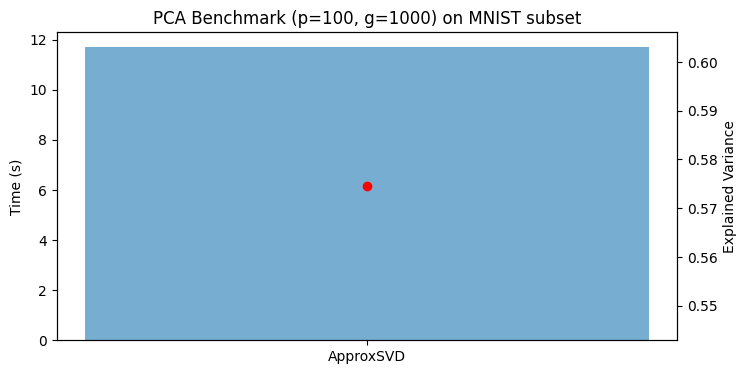

In [12]:

# np.random.seed(42) 
# X = np.random.rand(5, 8)
p = 100
g = 1000

results = run_benchmarks(X, p=p, g=g)

print("\nBenchmark Results:")
for r in results:
    print(f"{r['method']:15s} | Time: {r['time']:.2f}s | Explained Var: {r['explained_variance']*100:.2f}%")

# Optional: bar plot
methods = [r["method"] for r in results]
times = [r["time"] for r in results]
evrs = [r["explained_variance"] for r in results]

fig, ax1 = plt.subplots(figsize=(8,4))
ax2 = ax1.twinx()

ax1.bar(methods, times, alpha=0.6, label="Time (s)")
ax2.plot(methods, evrs, "o-", color="red", label="Explained Var")

ax1.set_ylabel("Time (s)")
ax2.set_ylabel("Explained Variance")
plt.title(f"PCA Benchmark (p={p}, g={g}) on MNIST subset")
plt.show()